# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.490888,False,0.978170
1,-1.009775,False,0.024681
2,-0.294268,False,1.071236
3,-1.046437,False,-0.715418
4,0.946581,False,1.973779
...,...,...,...
995,-2.210464,False,0.430126
996,0.960334,True,5.784131
997,-0.826623,False,-0.583120
998,-1.290634,False,-0.918254


<AxesSubplot: xlabel='v0'>

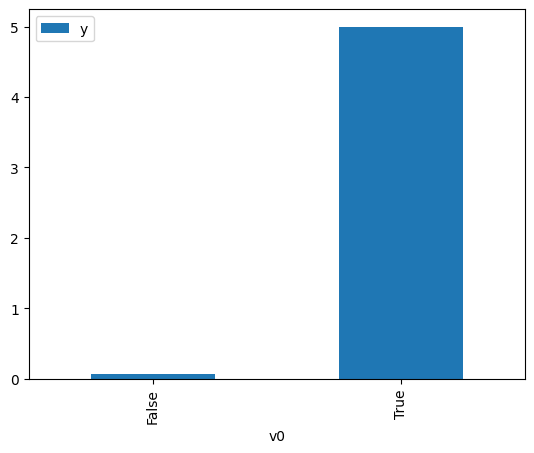

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

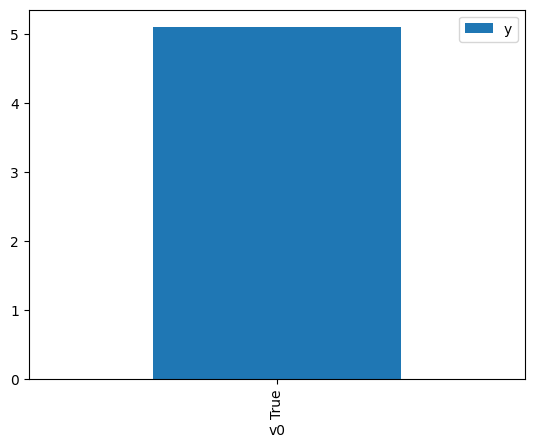

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.106832,False,-0.807673,0.726134,1.377156
1,-1.113066,False,0.233313,0.727004,1.375508
2,-1.282639,False,0.603939,0.750002,1.333330
3,-1.892370,False,1.698026,0.821573,1.217177
4,-3.159784,False,0.105794,0.918157,1.089138
...,...,...,...,...,...
995,-1.363305,False,0.476850,0.760478,1.314962
996,-0.739591,False,0.216242,0.671959,1.488185
997,-1.689709,False,0.278302,0.799736,1.250413
998,-2.137464,False,0.678875,0.845437,1.182820


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.352883,True,6.170282,0.390468,2.561031
1,0.632993,True,6.104504,0.561527,1.780858
2,-0.578314,True,4.471049,0.353488,2.828950
3,-2.288363,True,5.223470,0.141210,7.081659
4,-1.115047,True,6.096532,0.272720,3.666770
...,...,...,...,...,...
995,-0.250827,True,5.450562,0.407662,2.453012
996,-0.943817,True,5.225837,0.297223,3.364475
997,-2.952847,True,6.822065,0.093455,10.700388
998,-0.488184,True,3.531323,0.368091,2.716717


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.891
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              4092.
Date:                Fri, 03 Feb 2023   Prob (F-statistic):                        0.00
Time:                        05:49:55   Log-Likelihood:                         -1424.7
No. Observations:                1000   AIC:                                      2853.
Df Residuals:                     998   BIC:                                      2863.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0490      0.023      2.086      0.037       0.003       0.095
x2             5.0792      0.057     89.453      0.000       4.968       5.191
==============================================================================
Omnibus:                        2.656   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.458
Skew:                          -0.057   Prob(JB):                        0.293
Kurtosis:                       2.785   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""